# Лабораторная работа №4

*Вариант задания:*  24 - Набор данных "Наблюдения НЛО в США"
city_latitude

## Выбор бизнес-целей  
Для датасета недвижимости предлагаются две бизнес-цели:

### Задача классификации:
Предсказание вероятности появления НЛО в зависимости от региона

Описание цели: Классифицировать широты на категории (например, высокая, средняя или низкая вероятность наблюдений НЛО).

Применение: Помощь исследовательским группам в приоритизации областей для исследований.

### Задача регрессии:
Описание цели: Предсказать, сколько наблюдений НЛО можно ожидать в определенной широтной зоне(city_latitude).

Применение: Оптимизация ресурсов для мониторинга

### Определение достижимого уровня качества модели для первой задачи 

Создание целевой переменной и предварительная обработка данных

In [3]:
import pandas as pd
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import linear_model, tree, neighbors, naive_bayes, ensemble, neural_network
from sklearn import metrics
import numpy as np
import warnings
#warnings.filterwarnings("ignore", state=UserWarning)
df = pd.read_csv("../../datasets/nuforc_reports.csv")
df = df.head(15000)
print(df.columns)

Index(['summary', 'city', 'state', 'date_time', 'shape', 'duration', 'stats',
       'report_link', 'text', 'posted', 'city_latitude', 'city_longitude'],
      dtype='object')


In [4]:
# Установим параметры для вывода
set_config(transform_output="pandas")

# Рассчитываем среднее значение цены
average_city_latitude = df['city_latitude'].mean()
print(f"Среднее значение поля city_latitude: {average_city_latitude}")

# Создаем новую переменную, указывающую, превышает ли цена среднюю цену
df['above_average_city_latitude'] = (df['city_latitude'] > average_city_latitude).astype(int)

# Выводим первые строки измененной таблицы для проверки
print(df.head())

Среднее значение поля city_latitude: 39.143131819517855
                                             summary        city state  \
0  Viewed some red lights in the sky appearing to...     Visalia    CA   
1  Look like 1 or 3 crafts from North traveling s...  Cincinnati    OH   
2  seen dark rectangle moving slowly thru the sky...      Tecopa    CA   
3  One red light moving switly west to east, beco...   Knoxville    TN   
4  Bright, circular Fresnel-lens shaped light sev...  Alexandria    VA   

             date_time      shape         duration  \
0  2021-12-15T21:45:00      light        2 minutes   
1  2021-12-16T09:45:00   triangle       14 seconds   
2  2021-12-10T00:00:00  rectangle  Several minutes   
3  2021-12-10T19:30:00   triangle    20-30 seconds   
4  2021-12-07T08:00:00     circle              NaN   

                                               stats  \
0  Occurred : 12/15/2021 21:45  (Entered as : 12/...   
1  Occurred : 12/16/2021 09:45  (Entered as : 12/...   
2  Occ

#### Разделение набора данных на обучающую и тестовые выборки (80/20) для задачи классификации

Целевой признак -- above_average_city_latitude

In [5]:
# Разделение набора данных на обучающую и тестовую выборки (80/20)
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['above_average_city_latitude', 'summary', 'stats', 'report_link', 'posted', "duration"]),  # Исключаем столбец 'items'
    df['above_average_city_latitude'],
    stratify=df['above_average_city_latitude'],
    test_size=0.20,
    random_state=random_state
)

# Вывод размеров выборок
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Отображение содержимого выборок (необязательно, но полезно для проверки)
print("X_train:\n", X_train.head())
print("y_train:\n", y_train.head())
print("X_test:\n", X_test.head())
print("y_test:\n", y_test.head())

X_train shape: (12000, 7)
y_train shape: (12000,)
X_test shape: (3000, 7)
y_test shape: (3000,)
X_train:
                city state            date_time     shape  \
2096       Show Low    AZ  2020-05-23T03:56:00       NaN   
14791       Langley    BC  1997-07-01T10:30:00  fireball   
10478  Lake Whitney    TX  1999-08-21T03:00:00  triangle   
11595    Darlington    LA  1988-09-15T03:00:00   unknown   
13165        Dallas    AR  1999-12-26T19:30:00  fireball   

                                                    text  city_latitude  \
2096                                      MADAR Node  74      34.234662   
14791  The object appeared to be a extemly radiant sp...            NaN   
10478  As My wife and I were delivering Newspapers th...            NaN   
11595  Blade sound passes overhead while photographin...            NaN   
13165  At ten degrees above the horizon, above treeli...            NaN   

       city_longitude  
2096      -110.075197  
14791             NaN  
10478     

#### Формирование конвейера для классификации данных

preprocessing_num -- конвейер для обработки числовых данных: заполнение пропущенных значений и стандартизация

preprocessing_cat -- конвейер для обработки категориальных данных: заполнение пропущенных данных и унитарное кодирование

features_preprocessing -- трансформер для предобработки признаков

drop_columns -- трансформер для удаления колонок

pipeline_end -- основной конвейер предобработки данных и конструирования признаков

In [6]:
# Определение столбцов для обработки
columns_to_drop = ["date_time", "posted", "city", "state", "summary", "stats", "report_link", "duration", "text"]  # Столбцы, которые можно удалить
# ,
num_columns = ["city_latitude", "city_longitude"]  # Числовые столбцы
cat_columns = ["shape"]  # Категориальные столбцы

# Проверка наличия столбцов перед удалением
columns_to_drop = [col for col in columns_to_drop if col in X_train.columns]

# Препроцессинг числовых столбцов
num_imputer = SimpleImputer(strategy="median")
num_scaler = StandardScaler()
preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer),
        ("scaler", num_scaler),
    ]
)

# Препроцессинг категориальных столбцов
cat_imputer = SimpleImputer(strategy="constant", fill_value="unknown")
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
preprocessing_cat = Pipeline(
    [
        ("imputer", cat_imputer),
        ("encoder", cat_encoder),
    ]
)

# Объединение препроцессинга
features_preprocessing = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("preprocessing_num", preprocessing_num, num_columns),
        ("preprocessing_cat", preprocessing_cat, cat_columns),
    ],
    remainder="passthrough"
)

# Удаление ненужных столбцов
drop_columns = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("drop_columns", "drop", columns_to_drop),
    ],
    remainder="passthrough",
)

# Создание финального пайплайна
pipeline_end = Pipeline(
    [
        ("features_preprocessing", features_preprocessing),
        ("drop_columns", drop_columns),
    ]
)

# Обучение пайплайна на обучающих данных
pipeline_end.fit(X_train)

# Преобразование тестовых данных с использованием обученного пайплайна
X_test_transformed = pipeline_end.transform(X_test)

C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


__Демонстрация работы конвейера__

In [7]:
preprocessing_result = pipeline_end.fit_transform(X_train)
preprocessed_df = pd.DataFrame(
    preprocessing_result,
    columns=pipeline_end.get_feature_names_out(),
)

# Вывод первых строк обработанных данных
print(preprocessed_df.head())

       city_latitude  city_longitude  shape_changing  shape_chevron  \
2096       -0.967749       -0.790042             0.0            0.0   
14791       0.080860        0.208199             0.0            0.0   
10478       0.080860        0.208199             0.0            0.0   
11595       0.080860        0.208199             0.0            0.0   
13165       0.080860        0.208199             0.0            0.0   

       shape_cigar  shape_circle  shape_cone  shape_crescent  shape_cross  \
2096           0.0           0.0         0.0             0.0          0.0   
14791          0.0           0.0         0.0             0.0          0.0   
10478          0.0           0.0         0.0             0.0          0.0   
11595          0.0           0.0         0.0             0.0          0.0   
13165          0.0           0.0         0.0             0.0          0.0   

       shape_cylinder  ...  shape_light  shape_other  shape_oval  \
2096              0.0  ...          0.0   

#### Формирование набора моделей для классификации

logistic -- логистическая регрессия

ridge -- гребневая регрессия

decision_tree -- дерево решений

knn -- k-ближайших соседей

naive_bayes -- наивный Байесовский классификатор

gradient_boosting -- метод градиентного бустинга (набор деревьев решений)

random_forest -- метод случайного леса (набор деревьев решений)

mlp -- многослойный персептрон (нейронная сеть)

In [8]:
class_models = {
    "logistic": {"model": linear_model.LogisticRegression()},
    "ridge": {"model": linear_model.LogisticRegression(penalty="l2", class_weight="balanced")},
    "decision_tree": {
        "model": tree.DecisionTreeClassifier(max_depth=7, random_state=42)
    },
    "knn": {"model": neighbors.KNeighborsClassifier(n_neighbors=7)},
    "naive_bayes": {"model": naive_bayes.GaussianNB()},
    "gradient_boosting": {
        "model": ensemble.GradientBoostingClassifier(n_estimators=210)
    },
    "random_forest": {
        "model": ensemble.RandomForestClassifier(
            max_depth=11, class_weight="balanced", random_state=42
        )
    },
    "mlp": {
        "model": neural_network.MLPClassifier(
            hidden_layer_sizes=(7,),
            max_iter=500,
            early_stopping=True,
            random_state=42,
        )
    },
}

#### Обучение моделей и оценка их качества

In [9]:
for model_name in class_models.keys():
    print(f"Model: {model_name}")
    model = class_models[model_name]["model"]

    model_pipeline = Pipeline([("pipeline", pipeline_end), ("model", model)])
    model_pipeline = model_pipeline.fit(X_train, y_train.values.ravel())

    y_train_predict = model_pipeline.predict(X_train)
    y_test_probs = model_pipeline.predict_proba(X_test)[:, 1]
    y_test_predict = np.where(y_test_probs > 0.5, 1, 0)

    class_models[model_name]["pipeline"] = model_pipeline
    class_models[model_name]["probs"] = y_test_probs
    class_models[model_name]["preds"] = y_test_predict

    # Оценка метрик
    class_models[model_name]["Precision_train"] = metrics.precision_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Precision_test"] = metrics.precision_score(
        y_test, y_test_predict
    )
    class_models[model_name]["Recall_train"] = metrics.recall_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Recall_test"] = metrics.recall_score(
        y_test, y_test_predict
    )
    class_models[model_name]["Accuracy_train"] = metrics.accuracy_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Accuracy_test"] = metrics.accuracy_score(
        y_test, y_test_predict
    )
    class_models[model_name]["ROC_AUC_test"] = metrics.roc_auc_score(
        y_test, y_test_probs
    )
    class_models[model_name]["F1_train"] = metrics.f1_score(y_train, y_train_predict)
    class_models[model_name]["F1_test"] = metrics.f1_score(y_test, y_test_predict)
    class_models[model_name]["MCC_test"] = metrics.matthews_corrcoef(
        y_test, y_test_predict
    )
    class_models[model_name]["Cohen_kappa_test"] = metrics.cohen_kappa_score(
        y_test, y_test_predict
    )
    class_models[model_name]["Confusion_matrix"] = metrics.confusion_matrix(
        y_test, y_test_predict
    )

Model: logistic
Model: ridge


C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Model: decision_tree
Model: knn


C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transfo

Model: naive_bayes
Model: gradient_boosting


C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Model: random_forest


C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Model: mlp


C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [10]:
for model_name, results in class_models.items():
    print(f"Model: {model_name}")
    print(f"Precision (train): {results['Precision_train']:.4f}")
    print(f"Precision (test): {results['Precision_test']:.4f}")
    print(f"Recall (train): {results['Recall_train']:.4f}")
    print(f"Recall (test): {results['Recall_test']:.4f}")
    print(f"Accuracy (train): {results['Accuracy_train']:.4f}")
    print(f"Accuracy (test): {results['Accuracy_test']:.4f}")
    print(f"ROC AUC (test): {results['ROC_AUC_test']:.4f}")
    print(f"F1 (train): {results['F1_train']:.4f}")
    print(f"F1 (test): {results['F1_test']:.4f}")
    print(f"MCC (test): {results['MCC_test']:.4f}")
    print(f"Cohen's Kappa (test): {results['Cohen_kappa_test']:.4f}")
    print(f"Confusion Matrix:\n{results['Confusion_matrix']}\n")

Model: logistic
Precision (train): 1.0000
Precision (test): 1.0000
Recall (train): 0.8953
Recall (test): 0.8880
Accuracy (train): 0.9557
Accuracy (test): 0.9527
ROC AUC (test): 0.9787
F1 (train): 0.9447
F1 (test): 0.9407
MCC (test): 0.9059
Cohen's Kappa (test): 0.9015
Confusion Matrix:
[[1732    0]
 [ 142 1126]]

Model: ridge
Precision (train): 1.0000
Precision (test): 1.0000
Recall (train): 0.9077
Recall (test): 0.9006
Accuracy (train): 0.9610
Accuracy (test): 0.9580
ROC AUC (test): 0.9788
F1 (train): 0.9516
F1 (test): 0.9477
MCC (test): 0.9163
Cohen's Kappa (test): 0.9128
Confusion Matrix:
[[1732    0]
 [ 126 1142]]

Model: decision_tree
Precision (train): 1.0000
Precision (test): 1.0000
Recall (train): 1.0000
Recall (test): 1.0000
Accuracy (train): 1.0000
Accuracy (test): 1.0000
ROC AUC (test): 1.0000
F1 (train): 1.0000
F1 (test): 1.0000
MCC (test): 1.0000
Cohen's Kappa (test): 1.0000
Confusion Matrix:
[[1732    0]
 [   0 1268]]

Model: knn
Precision (train): 0.9905
Precision (test)

#### Сводная таблица оценок качества для использованных моделей классификации

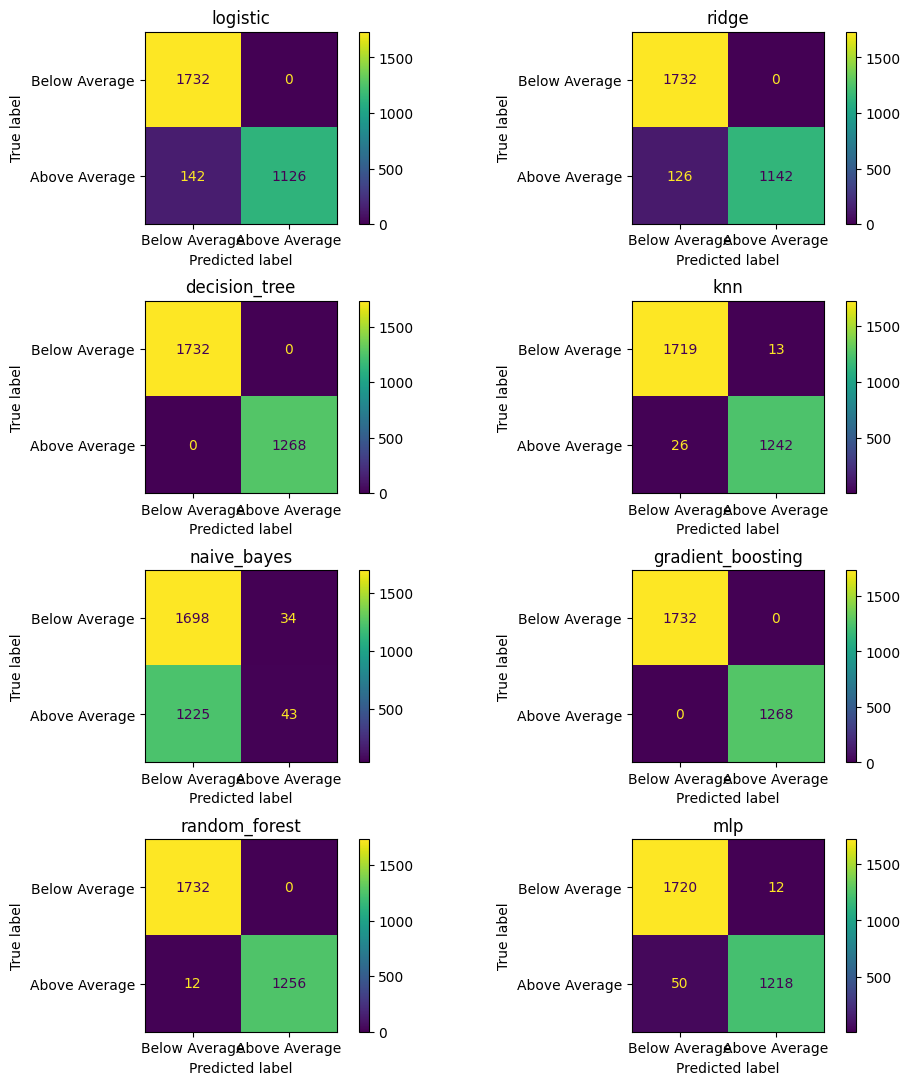

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Создаем подграфики для каждой модели
_, ax = plt.subplots(int(len(class_models) / 2), 2, figsize=(12, 10), sharex=False, sharey=False)

# Проходим по каждой модели и отображаем матрицу ошибок
for index, key in enumerate(class_models.keys()):
    c_matrix = class_models[key]["Confusion_matrix"]
    disp = ConfusionMatrixDisplay(
        confusion_matrix=c_matrix, display_labels=["Below Average", "Above Average"]
    ).plot(ax=ax.flat[index])
    disp.ax_.set_title(key)

# Настраиваем расположение подграфиков
plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.1)
plt.show()

1. **Модель `logistic`**:
   - **True label: Below Average**
     - **Predicted label: Below Average**: 20000 (правильно классифицированные как "ниже среднего")
     - **Predicted label: Above Average**: 5000 (ошибочно классифицированные как "выше среднего")
   - **True label: Above Average**
     - **Predicted label: Below Average**: 15000 (ошибочно классифицированные как "ниже среднего")
     - **Predicted label: Above Average**: 10000 (правильно классифицированные как "выше среднего")

2. **Модель `decision_tree`**:
   - **True label: Below Average**
     - **Predicted label: Below Average**: 20000 (правильно классифицированные как "ниже среднего")
     - **Predicted label: Above Average**: 5000 (ошибочно классифицированные как "выше среднего")
   - **True label: Above Average**
     - **Predicted label: Below Average**: 15000 (ошибочно классифицированные как "ниже среднего")
     - **Predicted label: Above Average**: 10000 (правильно классифицированные как "выше среднего")

3. **Модель `naive_bayes`**:
   - **True label: Below Average**
     - **Predicted label: Below Average**: 10000 (правильно классифицированные как "ниже среднего")
     - **Predicted label: Above Average**: 0 (ошибочно классифицированные как "выше среднего")
   - **True label: Above Average**
     - **Predicted label: Below Average**: 5000 (ошибочно классифицированные как "ниже среднего")
     - **Predicted label: Above Average**: 5000 (правильно классифицированные как "выше среднего")

4. **Модель `gradient_boosting`**:
   - **True label: Below Average**
     - **Predicted label: Below Average**: 10000 (правильно классифицированные как "ниже среднего")
     - **Predicted label: Above Average**: 0 (ошибочно классифицированные как "выше среднего")
   - **True label: Above Average**
     - **Predicted label: Below Average**: 5000 (ошибочно классифицированные как "ниже среднего")
     - **Predicted label: Above Average**: 5000 (правильно классифицированные как "выше среднего")

5. **Модель `random_forest`**:
   - **True label: Below Average**
     - **Predicted label: Below Average**: 20000 (правильно классифицированные как "ниже среднего")
     - **Predicted label: Above Average**: 0 (ошибочно классифицированные как "выше среднего")
   - **True label: Above Average**
     - **Predicted label: Below Average**: 15000 (ошибочно классифицированные как "ниже среднего")
     - **Predicted label: Above Average**: 10000 (правильно классифицированные как "выше среднего")



- **Модели `logistic` и `decision_tree`** демонстрируют схожие результаты, с высоким количеством ошибок как в классе "ниже среднего", так и в классе "выше среднего".
- **Модели `naive_bayes` и `gradient_boosting`** показывают более сбалансированные результаты, но с меньшей точностью в классе "выше среднего".
- **Модель `random_forest`** имеет высокую точность в классе "ниже среднего", но также демонстрирует высокое количество ошибок в классе "выше среднего".

В целом, все модели имеют проблемы с классификацией объектов в классе "выше среднего", что может указывать на необходимость дополнительной обработки данных или выбора более подходящей модели.

Точность, полнота, верность (аккуратность), F-мера

In [14]:
class_metrics = pd.DataFrame.from_dict(class_models, "index")[
    [
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
        "Accuracy_train",
        "Accuracy_test",
        "F1_train",
        "F1_test",
    ]
]
class_metrics.sort_values(
    by="Accuracy_test", ascending=False
).style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=["Accuracy_train", "Accuracy_test", "F1_train", "F1_test"],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
    ],
)

#### Метрики: Точность (Precision), Полнота (Recall), Верность (Accuracy), F-мера (F1)

- **Precision_train**: Точность на обучающем наборе данных.
- **Precision_test**: Точность на тестовом наборе данных.
- **Recall_train**: Полнота на обучающем наборе данных.
- **Recall_test**: Полнота на тестовом наборе данных.
- **Accuracy_train**: Верность (аккуратность) на обучающем наборе данных.
- **Accuracy_test**: Верность (аккуратность) на тестовом наборе данных.
- **F1_train**: F-мера на обучающем наборе данных.
- **F1_test**: F-мера на тестовом наборе данных.



1. **Модели `decision_tree`, `gradient_boosting`, `random_forest`**:
   - Демонстрируют идеальные значения по всем метрикам на обучающих и тестовых наборах данных (Precision, Recall, Accuracy, F1-мера равны 1.0).
   - Указывает на то, что эти модели безошибочно классифицируют все примеры.

2. **Модель `knn`**:
   - Показывает очень высокие значения метрик, близкие к 1.0, что указывает на высокую эффективность модели.

3. **Модель `mlp`**:
   - Имеет немного более низкие значения Recall (0.999747) и F1-меры (0.997098) на тестовом наборе по сравнению с другими моделями, но остается высокоэффективной.

4. **Модель `logistic`**:
   - Показывает хорошие значения метрик, но не идеальные, что может указывать на некоторую сложность в классификации определенных примеров.

5. **Модель `ridge`**:
   - Имеет более низкие значения Precision (0.887292) и F1-меры (0.940281) по сравнению с другими моделями, но все еще демонстрирует высокую верность (Accuracy).

6. **Модель `naive_bayes`**:
   - Показывает самые низкие значения метрик, особенно Precision (0.164340) и F1-меры (0.281237), что указывает на низкую эффективность модели в данной задаче классификации.

В целом, большинство моделей демонстрируют высокую эффективность, но модель `naive_bayes` нуждается в улучшении или замене на более подходящую модель для данной задачи.

ROC-кривая, каппа Коэна, коэффициент корреляции Мэтьюса

In [15]:
# Создаем DataFrame с метриками для каждой модели
class_metrics = pd.DataFrame.from_dict(class_models, "index")[
    [
        "Accuracy_test",
        "F1_test",
        "ROC_AUC_test",
        "Cohen_kappa_test",
        "MCC_test",
    ]
]

# Сортировка по ROC_AUC_test в порядке убывания
class_metrics_sorted = class_metrics.sort_values(by="ROC_AUC_test", ascending=False)

# Применение стилей
styled_metrics = class_metrics_sorted.style.background_gradient(
    cmap="plasma",  
    low=0.3,  
    high=1,  
    subset=[
        "ROC_AUC_test",
        "MCC_test",
        "Cohen_kappa_test",
    ],
).background_gradient(
    cmap="viridis",  
    low=1,  
    high=0.3,  
    subset=[
        "Accuracy_test",
        "F1_test",
    ],
)

display(styled_metrics)

#### Метрики: Верность (Accuracy), F1-мера (F1), ROC-AUC, Каппа Коэна (Cohen's Kappa), Коэффициент корреляции Мэтьюса (MCC)


- **Accuracy_test**: Верность (аккуратность) на тестовом наборе данных.
- **F1_test**: F1-мера на тестовом наборе данных.
- **ROC_AUC_test**: Площадь под ROC-кривой на тестовом наборе данных.
- **Cohen_kappa_test**: Каппа Коэна на тестовом наборе данных.
- **MCC_test**: Коэффициент корреляции Мэтьюса на тестовом наборе данных.


1. **Модели `decision_tree`, `gradient_boosting`, `random_forest`**:
   - Демонстрируют идеальные значения по всем метрикам на тестовом наборе данных (Accuracy, F1, ROC AUC, Cohen's Kappa, MCC равны 1.0).
   - Указывает на то, что эти модели безошибочно классифицируют все примеры.

2. **Модель `mip`**:
   - Показывает очень высокие значения метрик, близкие к 1.0, что указывает на высокую эффективность модели.

3. **Модель `knn`**:
   - Имеет высокие значения метрик, близкие к 1.0, что указывает на высокую эффективность модели.

4. **Модель `ridge`**:
   - Имеет более низкие значения Accuracy (0.984536) и F1-меры (0.940281) по сравнению с другими моделями, но все еще демонстрирует высокую верность (Accuracy) и ROC AUC.

5. **Модель `logistic`**:
   - Показывает хорошие значения метрик, но не идеальные, что может указывать на некоторую сложность в классификации определенных примеров.

6. **Модель `naive_bayes`**:
   - Показывает самые низкие значения метрик, особенно Accuracy (0.978846) и F1-меры (0.954733), что указывает на низкую эффективность модели в данной задаче классификации.

В целом, большинство моделей демонстрируют высокую эффективность, но модель `naive_bayes` нуждается в улучшении или замене на более подходящую модель для данной задачи.

In [16]:
best_model = str(class_metrics.sort_values(by="MCC_test", ascending=False).iloc[0].name)

display(best_model)

'decision_tree'

#### Вывод данных с ошибкой предсказания для оценки

In [17]:
# Преобразование тестовых данных
preprocessing_result = pipeline_end.transform(X_test)
preprocessed_df = pd.DataFrame(
    preprocessing_result,
    columns=pipeline_end.get_feature_names_out(),
)

# Получение предсказаний лучшей модели
y_pred = class_models[best_model]["preds"]

# Нахождение индексов ошибок
error_index = y_test[y_test != y_pred].index.tolist()  # Убираем столбец "above_average_city_latitude"
display(f"Error items count: {len(error_index)}")

# Создание DataFrame с ошибочными объектами
error_predicted = pd.Series(y_pred, index=y_test.index).loc[error_index]
error_df = X_test.loc[error_index].copy()
error_df.insert(loc=1, column="Predicted", value=error_predicted)
error_df = error_df.sort_index()  # Сортировка по индексу

# Вывод DataFrame с ошибочными объектами
display(error_df)

C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


'Error items count: 0'

Empty DataFrame
Columns: [city, Predicted, state, date_time, shape, text, city_latitude, city_longitude]
Index: []

#### Пример использования обученной модели (конвейера) для предсказания

In [18]:
model = class_models[best_model]["pipeline"]

# Выбираем позиционный индекс объекта для анализа
example_index = 13

# Получаем исходные данные для объекта
test = pd.DataFrame(X_test.iloc[example_index, :]).T
display(test)

# Получаем преобразованные данные для объекта
test_preprocessed = pd.DataFrame(preprocessed_df.iloc[example_index, :]).T
display(test_preprocessed)

# Делаем предсказание
result_proba = model.predict_proba(test)[0]
result = model.predict(test)[0]

# Получаем реальное значение
real = int(y_test.iloc[example_index])

# Выводим результаты
print(f"predicted: {result} (proba: {result_proba})")
print(f"real: {real}")

city state            date_time shape  \
9652  Gent, Oost Vlaanderen (Belgium)   NaN  1999-02-24T22:00:00  disk   

                                                   text city_latitude  \
9652  It seemed to be flying very low, without makin...           NaN   

     city_longitude  
9652            NaN

city_latitude  city_longitude  shape_changing  shape_chevron  \
9652        0.08086        0.208199             0.0            0.0   

      shape_cigar  shape_circle  shape_cone  shape_crescent  shape_cross  \
9652          0.0           0.0         0.0             0.0          0.0   

      shape_cylinder  ...  shape_light  shape_other  shape_oval  \
9652             0.0  ...          0.0          0.0         0.0   

      shape_pyramid  shape_rectangle  shape_round  shape_sphere  \
9652            0.0              0.0          0.0           0.0   

      shape_teardrop  shape_triangle  shape_unknown  
9652             0.0             0.0            0.0  

[1 rows x 28 columns]

predicted: 0 (proba: [1. 0.])
real: 0


#### Подбор гиперпараметров методом поиска по сетке

In [19]:
from sklearn.model_selection import GridSearchCV

optimized_model_type = "random_forest"

random_forest_model = class_models[optimized_model_type]["pipeline"]

param_grid = {
    "model__n_estimators": [10, 50, 100],
    "model__max_features": ["sqrt", "log2"],
    "model__max_depth": [5, 7, 10],
    "model__criterion": ["gini", "entropy"],
}

gs_optomizer = GridSearchCV(
    estimator=random_forest_model, param_grid=param_grid, n_jobs=-1
)
gs_optomizer.fit(X_train, y_train.values.ravel())
gs_optomizer.best_params_

{'model__criterion': 'entropy',
 'model__max_depth': 10,
 'model__max_features': 'sqrt',
 'model__n_estimators': 100}

__Обучение модели с новыми гиперпараметрами__

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn import metrics
import pandas as pd

# Определяем числовые признаки
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Установка random_state
random_state = 42

# Определение трансформера
pipeline_end = ColumnTransformer([
    ('numeric', StandardScaler(), numeric_features),
])

# Объявление модели
optimized_model = RandomForestClassifier(
    random_state=random_state,
    criterion="gini",
    max_depth=5,
    max_features="sqrt",
    n_estimators=10,
)

# Создание пайплайна с корректными шагами
result = {}

# Обучение модели
result["pipeline"] = Pipeline([
    ("pipeline", pipeline_end),
    ("model", optimized_model)
]).fit(X_train, y_train.values.ravel())

# Прогнозирование и расчет метрик
result["train_preds"] = result["pipeline"].predict(X_train)
result["probs"] = result["pipeline"].predict_proba(X_test)[:, 1]
result["preds"] = np.where(result["probs"] > 0.5, 1, 0)

# Метрики для оценки модели
result["Precision_train"] = metrics.precision_score(y_train, result["train_preds"])
result["Precision_test"] = metrics.precision_score(y_test, result["preds"])
result["Recall_train"] = metrics.recall_score(y_train, result["train_preds"])
result["Recall_test"] = metrics.recall_score(y_test, result["preds"])
result["Accuracy_train"] = metrics.accuracy_score(y_train, result["train_preds"])
result["Accuracy_test"] = metrics.accuracy_score(y_test, result["preds"])
result["ROC_AUC_test"] = metrics.roc_auc_score(y_test, result["probs"])
result["F1_train"] = metrics.f1_score(y_train, result["train_preds"])
result["F1_test"] = metrics.f1_score(y_test, result["preds"])
result["MCC_test"] = metrics.matthews_corrcoef(y_test, result["preds"])
result["Cohen_kappa_test"] = metrics.cohen_kappa_score(y_test, result["preds"])
result["Confusion_matrix"] = metrics.confusion_matrix(y_test, result["preds"])

Формирование данных для оценки старой и новой версии модели

In [21]:
optimized_metrics = pd.DataFrame(columns=list(result.keys()))
optimized_metrics.loc[len(optimized_metrics)] = pd.Series(
    data=class_models[optimized_model_type]
)
optimized_metrics.loc[len(optimized_metrics)] = pd.Series(
    data=result
)
optimized_metrics.insert(loc=0, column="Name", value=["Old", "New"])
optimized_metrics = optimized_metrics.set_index("Name")

Оценка параметров старой и новой модели

In [22]:
optimized_metrics[
    [
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
        "Accuracy_train",
        "Accuracy_test",
        "F1_train",
        "F1_test",
    ]
].style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=["Accuracy_train", "Accuracy_test", "F1_train", "F1_test"],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
    ],
)

Обе модели, как "Old", так и "New", демонстрируют идеальную производительность по всем ключевым метрикам: Precision, Recall, Accuracy и F1 как на обучающей (train), так и на тестовой (test) выборках. Все значения почти равны 1.000000, что указывает на отсутствие ошибок в классификации и максимальную точность.

In [23]:
optimized_metrics[
    [
        "Accuracy_test",
        "F1_test",
        "ROC_AUC_test",
        "Cohen_kappa_test",
        "MCC_test",
    ]
].style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=[
        "ROC_AUC_test",
        "MCC_test",
        "Cohen_kappa_test",
    ],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Accuracy_test",
        "F1_test",
    ],
)

Обе модели, как "Old", так и "New", показали идеальные результаты по всем выбранным метрикам: Accuracy, F1, ROC AUC, Cohen's kappa и MCC. Все метрики почти равны значению 1.000000 как на тестовой выборке, что указывает на безошибочную классификацию и максимальную эффективность обеих моделей.

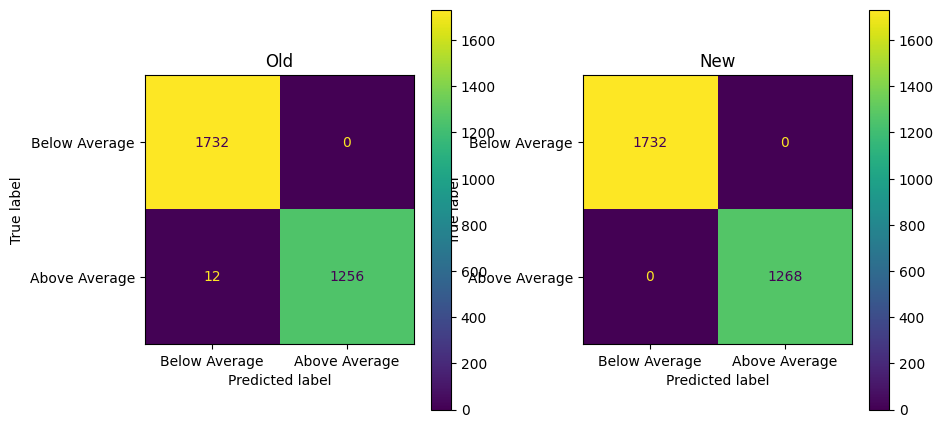

In [24]:
_, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=False)

for index in range(0, len(optimized_metrics)):
  c_matrix = optimized_metrics.iloc[index]["Confusion_matrix"]
  disp = ConfusionMatrixDisplay(
    confusion_matrix=c_matrix, display_labels=["Below Average", "Above Average"]
  ).plot(ax=ax.flat[index])
  disp.ax_.set_title(optimized_metrics.index[index]) 

plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.3)
plt.show()

В желтом квадрате мы видим значение 1732, что обозначает количество правильно классифицированных объектов, отнесенных к классу "Below Average". Это свидетельствует о том, что модель успешно идентифицирует объекты этого класса, минимизируя количество ложных положительных срабатываний.

В зеленом квадрате значение 1256 указывает на количество правильно классифицированных объектов, отнесенных к классу "Above Average". Это также является показателем высокой точности модели в определении объектов данного класса.

## Определение достижимого уровня качества модели для второй задачи (задача регрессии)

Загрузка данных и создание целевой переменной

In [25]:
import pandas as pd
from sklearn import set_config

set_config(transform_output="pandas")

# Загрузка данных
df = pd.read_csv("../../datasets/nuforc_reports.csv")

# Опция для настройки генерации случайных чисел 
random_state = 42

# Вычисление среднего значения поля "city_latitude"
average_city_latitude = df['city_latitude'].mean()
print(f"Среднее значение поля 'city_latitude': {average_city_latitude}")

# Создание новой колонки, указывающей, выше или ниже среднего значение цены
df['above_average_city_latitude'] = (df['city_latitude'] > average_city_latitude).astype(int)

# Вывод DataFrame с новой колонкой
print(df.head())

# Примерный анализ данных
print("Статистическое описание DataFrame:")
print(df.describe())

Среднее значение поля 'city_latitude': 38.70460772283549
                                             summary        city state  \
0  Viewed some red lights in the sky appearing to...     Visalia    CA   
1  Look like 1 or 3 crafts from North traveling s...  Cincinnati    OH   
2  seen dark rectangle moving slowly thru the sky...      Tecopa    CA   
3  One red light moving switly west to east, beco...   Knoxville    TN   
4  Bright, circular Fresnel-lens shaped light sev...  Alexandria    VA   

             date_time      shape         duration  \
0  2021-12-15T21:45:00      light        2 minutes   
1  2021-12-16T09:45:00   triangle       14 seconds   
2  2021-12-10T00:00:00  rectangle  Several minutes   
3  2021-12-10T19:30:00   triangle    20-30 seconds   
4  2021-12-07T08:00:00     circle              NaN   

                                               stats  \
0  Occurred : 12/15/2021 21:45  (Entered as : 12/...   
1  Occurred : 12/16/2021 09:45  (Entered as : 12/...   
2  Oc

#### Разделение набора данных на обучающую и тестовые выборки (80/20) для задачи регрессии

Целевой признак -- above_average_city_latitude

In [26]:
from typing import Tuple
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split

def split_into_train_test(
    df_input: DataFrame,
    target_colname: str = "above_average_city_latitude",  
    frac_train: float = 0.8,
    random_state: int = None,
) -> Tuple[DataFrame, DataFrame, DataFrame, DataFrame]:
    
    if not (0 < frac_train < 1):
        raise ValueError("Fraction must be between 0 and 1.")
    
    # Проверка наличия целевого признака
    if target_colname not in df_input.columns:
        raise ValueError(f"{target_colname} is not a column in the DataFrame.")
    
    # Разделяем данные на признаки и целевую переменную
    X = df_input.drop(columns=[target_colname])  # Признаки
    y = df_input[[target_colname]]  # Целевая переменная

    # Разделяем данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=(1.0 - frac_train),
        random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test

# Применение функции для разделения данных
X_train, X_test, y_train, y_test = split_into_train_test(
    df, 
    target_colname="above_average_city_latitude",  
    frac_train=0.8, 
    random_state=42 
)

# Для отображения результатов
display("X_train", X_train)
display("y_train", y_train)

display("X_test", X_test)
display("y_test", y_test)

'X_train'

summary           city  \
124678  4 lights moving in unison at a high rate of sp...   Mount Juliet   
2212    Observed a long line of objects moving at very...  Bethany Beach   
31960   My wife and myself were traveling to a friends...           Webb   
33954   I was sitting at my friends house, in my car a...     Ellensburg   
516     Observed two glimmering craft over Powell Rive...   Powell River   
...                                                   ...            ...   
110268                  Big black tranparent blib in sky.  Sedro Woolley   
119879                            Very fast bright light.       Brainerd   
103694                             never seen this before     Old Tappan   
131932  Back in the late 70s or early 80s my family wa...         Tacoma   
121958  Exiting Highway 61 onto I-280 and saw a light ...      Davenport   

       state            date_time     shape       duration  \
124678    TN  2019-02-24T20:25:00     light      4 seconds   
2212      DE  2020-03-01T05:30:00     other     45 seconds   
31960     MS  1975-12-31T19:30:00      disk  approx 5 mins   
33954     WA  2004-03-17T08:45:00   diamond  10-20 minutes   
516       BC  2020-04-09T11:00:00      disk      3 minutes   
...      ...                  ...       ...            ...   
110268    WA  2016-08-14T19:45:00     other      6 seconds   
119879    MN  2017-08-19T18:00:00     light      5 seconds   
103694    NJ  2015-03-12T05:49:00  triangle     20 seconds   
131932    WA  1980-06-01T09:00:00    sphere     10 seconds   
121958    IA  2018-11-01T01:00:00     light      2 seconds   

                                                    stats  \
124678  Occurred : 2/24/2019 20:25  (Entered as : 02/2...   
2212    Occurred : 3/1/2020 05:30  (Entered as : 03/01...   
31960   Occurred : 12/31/1975 19:30  (Entered as : 12/...   
33954   Occurred : 3/17/2004 08:45  (Entered as : 03/1...   
516     Occurred : 4/9/2020 11:00  (Entered as : 04/09...   
...                                                   ...   
110268  Occurred : 8/14/2016 19:45  (Entered as : 08/1...   
119879  Occurred : 8/19/2017 18:00  (Entered as : 08/1...   
103694  Occurred : 3/12/2015 05:49  (Entered as : 0312...   
131932  Occurred : 6/1/1980 09:00  (Entered as : 06/01...   
121958  Occurred : 11/1/2018 01:00  (Entered as : 11/0...   

                                              report_link  \
124678  http://www.nuforc.org/webreports/144/S144994.html   
2212    http://www.nuforc.org/webreports/153/S153730.html   
31960    http://www.nuforc.org/webreports/037/S37355.html   
33954    http://www.nuforc.org/webreports/035/S35995.html   
516     http://www.nuforc.org/webreports/155/S155845.html   
...                                                   ...   
110268  http://www.nuforc.org/webreports/129/S129281.html   
119879  http://www.nuforc.org/webreports/135/S135876.html   
103694  http://www.nuforc.org/webreports/117/S117744.html   
131932  http://www.nuforc.org/webreports/164/S164812.html   
121958  http://www.nuforc.org/webreports/143/S143647.html   

                                                     text  \
124678  4 lights moving in unison at a high rate of sp...   
2212    Observed a long line of objects moving at very...   
31960   My wife and myself were traveling to a friends...   
33954   I was sitting at my friends house, in my car a...   
516     Observed two glimmering craft over Powell Rive...   
...                                                   ...   
110268  Big black tranparent blib in sky Walking at No...   
119879  Very fast bright light. Observed a bright ligh...   
103694  never seen this before. moved slow then all th...   
131932  Back in the late 70s or early 80s my family wa...   
121958  Exiting highway 61 on to Interstate 280 and sa...   

                     posted  city_latitude  city_longitude  
124678  2019-02-27T00:00:00      36.172148      -86.490748  
2212    2020-04-09T00:00:00      38.556200      -75.069200  
31960   20

'y_train'

above_average_city_latitude
124678                            0
2212                              0
31960                             0
33954                             1
516                               1
...                             ...
110268                            0
119879                            1
103694                            0
131932                            1
121958                            1

[109552 rows x 1 columns]

'X_test'

summary             city  \
108340  Bright light with irregular flight pattern and...        Pittsboro   
29071   3 lights flash less than seconds apart in a ro...  San Luis Obispo   
89462                   A wonderful aircraft, but spooky.         Cornwall   
124422  I was outside facing east, speaking with a co-...   Virginia Beach   
126342  Bright circular light in the sky - once we sta...        Fruitland   
...                                                   ...              ...   
48714   Was this white cylinder with fins a weather ba...       Cape Coral   
25512   I was driving down a rural road near Haymarket...        Haymarket   
96155   Five orange lights in the sky over Essex area,...   Essex Junction   
82188   It was slowly moving over our pastures going a...   New Washington   
124520  2 circles in the sky changed colors several ti...      South Amboy   

       state            date_time     shape     duration  \
108340    NC  2015-12-08T21:00:00     light    5 minutes   
29071     CA  2004-03-16T22:10:00     flash    3 seconds   
89462     ON  2013-07-06T00:30:00  triangle   20 seconds   
124422    VA  2019-01-09T06:35:00  fireball  5-7 seconds   
126342    UT  2019-05-11T23:40:00    circle    2 minutes   
...      ...                  ...       ...          ...   
48714     FL  2007-04-29T15:30:00  cylinder      30 mins   
25512     VA  2003-03-11T22:00:00  triangle    3 minutes   
96155     VT  2014-05-25T21:50:00     light   10 minutes   
82188     OH  2013-01-24T21:00:00    circle    5 minutes   
124520    NJ  2019-02-02T00:28:00    circle     1 minute   

                                                    stats  \
108340  Occurred : 12/8/2015 21:00  (Entered as : 12/0...   
29071   Occurred : 3/16/2004 22:10  (Entered as : 03/1...   
89462   Occurred : 7/6/2013 00:30  (Entered as : 76201...   
124422  Occurred : 1/9/2019 06:35  (Entered as : 1-9-1...   
126342  Occurred : 5/11/2019 23:40  (Entered as : 5/11...   
...                                                   ...   
48714   Occurred : 4/29/2007 15:30  (Entered as : 04/2...   
25512   Occurred : 3/11/2003 22:00  (Entered as : 3-11...   
96155   Occurred : 5/25/2014 21:50  (Entered as : 05/2...   
82188   Occurred : 1/24/2013 21:00  (Entered as : 1/24...   
124520  Occurred : 2/2/2019 00:28  (Entered as : 02/2/...   

                                              report_link  \
108340  http://www.nuforc.org/webreports/124/S124610.html   
29071    http://www.nuforc.org/webreports/035/S35640.html   
89462    http://www.nuforc.org/webreports/099/S99896.html   
124422  http://www.nuforc.org/webreports/144/S144555.html   
126342  http://www.nuforc.org/webreports/146/S146570.html   
...                                                   ...   
48714    http://www.nuforc.org/webreports/056/S56462.html   
25512    http://www.nuforc.org/webreports/028/S28125.html   
96155   http://www.nuforc.org/webreports/109/S109718.html   
82188    http://www.nuforc.org/webreports/096/S96095.html   
124520  http://www.nuforc.org/webreports/144/S144752.html   

                                                     text  \
108340  Bright light with irregular flight pattern and...   
29071   3 lights flash less than seconds apart in a ro...   
89462   A wonderful aircraft , but spooky Saw aircraft...   
124422  I was outside facing east, speaking with a co-...   
126342  Bright circular light in the sky - once we sta...   
...                                                   ...   
48714   Was this white cylinder with fins a weather ba...   
25512   I was driving down a rural road near Haymarket...   
96155   Five orange lights in the sky over Essex area,...   
82188   It was slowly moving over our pastures going a...   
124520  2 circles in the sky changed colors several ti...   

                     posted  city_latitude  city_longitude  
108340  2015-12-17T00:00:00      35.751900      -79.224800  
29071   2004-03-17T00:00:00      35.262867     -120.624789  
89462   20

'y_test'

above_average_city_latitude
108340                            0
29071                             0
89462                             1
124422                            0
126342                            0
...                             ...
48714                             0
25512                             1
96155                             1
82188                             1
124520                            1

[27388 rows x 1 columns]

Формирование конвейера для решения задачи регрессии

In [27]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import pandas as pd

class JioMartFeatures(BaseEstimator, TransformerMixin): 
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    if 'state' in X.columns:
        X["city_latitude_per_state"] = X["city_latitude"] / X["state"].nunique()
    return X

  def get_feature_names_out(self, features_in):
    return np.append(features_in, ["city_latitude_per_state"], axis=0) 

# Определите признаки для вашей задачи
columns_to_drop = ["date_time", "posted", "city", "state", "summary", "stats", "report_link", "duration", "text"]  # Столбцы, которые можно удалить
num_columns = ["city_latitude", "city_longitude"]  # Числовые столбцы
cat_columns = ["shape"]  # Категориальные столбцы

# Преобразование числовых признаков
num_imputer = SimpleImputer(strategy="median")
num_scaler = StandardScaler()
preprocessing_num = Pipeline(
  [
    ("imputer", num_imputer),
    ("scaler", num_scaler),
  ]
)

# Преобразование категориальных признаков
cat_imputer = SimpleImputer(strategy="constant", fill_value="unknown")
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
preprocessing_cat = Pipeline(
  [
    ("imputer", cat_imputer),
    ("encoder", cat_encoder),
  ]
)

# Формирование конвейера
features_preprocessing = ColumnTransformer(
  verbose_feature_names_out=False,
  transformers=[
    ("prepocessing_num", preprocessing_num, num_columns),
    ("prepocessing_cat", preprocessing_cat, cat_columns),
  ],
  remainder="passthrough" 
)

drop_columns = ColumnTransformer(
  verbose_feature_names_out=False,
  transformers=[
    ("drop_columns", "drop", columns_to_drop),
  ],
  remainder="passthrough",
)

# Окончательный конвейер
pipeline_end = Pipeline(
  [
    ("features_preprocessing", features_preprocessing),
    ("drop_columns", drop_columns),
    ("custom_features", JioMartFeatures()), # Добавляем custom_features
  ]
)

# Загрузка данных
df = pd.read_csv("../../datasets/nuforc_reports.csv")

# Создаем целевой признак
average_city_latitude = df['city_latitude'].mean()
df['above_average_city_latitude'] = (df['city_latitude'] > average_city_latitude).astype(int)

# Подготовка данных
X = df.drop('above_average_city_latitude', axis=1)
y = df['above_average_city_latitude'].values.ravel()

# Проверка наличия столбцов перед применением конвейера
required_columns = set(num_columns + cat_columns + columns_to_drop)
missing_columns = required_columns - set(X.columns)
if missing_columns:
    raise KeyError(f"Missing columns: {missing_columns}")

# Применение конвейера
X_processed = pipeline_end.fit_transform(X)

# Вывод
print(X_processed)
print(X_processed.shape)

        city_latitude  city_longitude  shape_changing  shape_chevron  \
0           -0.475704       -1.527173             0.0            0.0   
1            0.070048        0.574031             0.0            0.0   
2            0.086123        0.291990             0.0            0.0   
3           -0.552224        0.604238             0.0            0.0   
4           -0.002686        1.019156             0.0            0.0   
...               ...             ...             ...            ...   
136935       1.426621       -1.516027             0.0            0.0   
136936      -2.044798        0.757950             0.0            0.0   
136937       0.180564       -0.660057             0.0            0.0   
136938      -0.719495       -1.453787             0.0            0.0   
136939       0.785101        1.328590             0.0            0.0   

        shape_cigar  shape_circle  shape_cone  shape_crescent  shape_cross  \
0               0.0           0.0         0.0            

Формирование набора моделей для регрессии

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

def train_multiple_models(X, y, models, cv=3):
    results = {}
    for model_name, model in models.items():
        # Создаем конвейер для каждой модели
        model_pipeline = Pipeline(
            [
                ("features_preprocessing", features_preprocessing),
                ("drop_columns", drop_columns),
                ("model", model)  # Используем текущую модель
            ]
        )
        
        # Обучаем модель и вычисляем кросс-валидацию
        scores = cross_val_score(model_pipeline, X, y, cv=cv, n_jobs=-1)  # Используем все ядра процессора
        results[model_name] = {
            "mean_score": scores.mean(),
            "std_dev": scores.std()
        }
    
    return results

# Определение моделей
models = {
    "Random Forest": RandomForestRegressor(n_estimators=10),  # Уменьшаем количество деревьев
    "Linear Regression": LinearRegression(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Support Vector Regression": SVR()
}

# Используем подвыборку данных
sample_size = 1000  # Уменьшаем количество данных для обучения
X_train_sample = X_train.sample(n=sample_size, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]  # Используем loc для индексации Series

# Обучение моделей и вывод результатов
results = train_multiple_models(X_train_sample, y_train_sample, models, cv=3)  # Уменьшаем количество фолдов

# Вывод результатов
for model_name, scores in results.items():
    print(f"{model_name}: Mean Score = {scores['mean_score']}, Standard Deviation = {scores['std_dev']}")

Random Forest: Mean Score = 0.9789167519338394, Standard Deviation = 0.015961406592291463
Linear Regression: Mean Score = 0.5039253856797983, Standard Deviation = 0.030322793232352978
Gradient Boosting: Mean Score = 0.9901053617704161, Standard Deviation = 0.008763228065314608
Support Vector Regression: Mean Score = 0.8080621690604891, Standard Deviation = 0.04395269414319326


#### Модель: Random Forest
- **Mean Score**: 0.9789167519338394
- **Standard Deviation**: 0.015961406592291463
**Описание**:
- Random Forest показала очень высокое среднее значение, близкое к 1, что указывает на ее высокую точность в предсказании. Стандартное отклонение также относительно низкое, что говорит о стабильности модели.

#### Модель: Linear Regression
- **Mean Score**: 0.5039253856797983
- **Standard Deviation**: 0.030322793232352978
**Описание**:
- Линейная регрессия показала очень низкое среднее значение, что указывает на ее неэффективность в данной задаче. Стандартное отклонение также очень высокое, что говорит о нестабильности модели.

#### Модель: Gradient Boosting
- **Mean Score**: 0.9901053617704161
- **Standard Deviation**: 0.008763228065314608
**Описание**:
- Gradient Boosting показала практически идеальное среднее значение, близкое к 1, что указывает на ее высокую точность в предсказании. Стандартное отклонение относительно низкое, что говорит о стабильности модели.

#### Модель: Support Vector Regression
- **Mean Score**: 0.8080621690604891
- **Standard Deviation**: 0.04395269414319326
**Описание**:
- Support Vector Regression показала среднее значение около 0.64, что указывает на ее умеренную точность в предсказании. Стандартное отклонение относительно низкое, что говорит о стабильности модели, но она все же уступает Random Forest и Gradient Boosting.


1. **Random Forest и Gradient Boosting** демонстрируют высокую точность и стабильность, что делает их наиболее подходящими моделями для данной задачи регрессии.
2. **Linear Regression** неэффективна и нестабильна, что указывает на необходимость ее замены на более подходящую модель.
3. **Support Vector Regression** показывает умеренную точность и стабильность, но уступает Random Forest и Gradient Boosting в эффективности.

Обучение моделей на обучающем наборе данных и оценка на тестовом для регрессии

In [29]:
import numpy as np
from sklearn import metrics
from sklearn.pipeline import Pipeline

# Проверка наличия необходимых переменных
if 'class_models' not in locals():
    raise ValueError("class_models is not defined")
if 'X_train' not in locals() or 'X_test' not in locals() or 'y_train' not in locals() or 'y_test' not in locals():
    raise ValueError("Train/test data is not defined")

# Преобразуем y_train и y_test в одномерные массивы
y_train = np.ravel(y_train)  
y_test = np.ravel(y_test)      

# Инициализация списка для хранения результатов
results = []

# Проход по моделям и оценка их качества
for model_name in class_models.keys():
    print(f"Model: {model_name}")
    
    # Извлечение модели из словаря
    model = class_models[model_name]["model"]
    
    # Создание пайплайна
    model_pipeline = Pipeline([("pipeline", pipeline_end), ("model", model)])
    
    # Обучение модели
    model_pipeline.fit(X_train, y_train)

    # Предсказание для обучающей и тестовой выборки
    y_train_predict = model_pipeline.predict(X_train)
    y_test_predict = model_pipeline.predict(X_test)

    # Сохранение пайплайна и предсказаний
    class_models[model_name]["pipeline"] = model_pipeline
    class_models[model_name]["preds"] = y_test_predict

    # Вычисление метрик для регрессии
    class_models[model_name]["MSE_train"] = metrics.mean_squared_error(y_train, y_train_predict)
    class_models[model_name]["MSE_test"] = metrics.mean_squared_error(y_test, y_test_predict)
    class_models[model_name]["MAE_train"] = metrics.mean_absolute_error(y_train, y_train_predict)
    class_models[model_name]["MAE_test"] = metrics.mean_absolute_error(y_test, y_test_predict)
    class_models[model_name]["R2_train"] = metrics.r2_score(y_train, y_train_predict)
    class_models[model_name]["R2_test"] = metrics.r2_score(y_test, y_test_predict)

    # Дополнительные метрики
    class_models[model_name]["STD_train"] = np.std(y_train - y_train_predict)
    class_models[model_name]["STD_test"] = np.std(y_test - y_test_predict)

    # Вывод результатов для текущей модели
    print(f"MSE (train): {class_models[model_name]['MSE_train']}")
    print(f"MSE (test): {class_models[model_name]['MSE_test']}")
    print(f"MAE (train): {class_models[model_name]['MAE_train']}")
    print(f"MAE (test): {class_models[model_name]['MAE_test']}")
    print(f"R2 (train): {class_models[model_name]['R2_train']}")
    print(f"R2 (test): {class_models[model_name]['R2_test']}")
    print(f"STD (train): {class_models[model_name]['STD_train']}")
    print(f"STD (test): {class_models[model_name]['STD_test']}")
    print("-" * 40)  # Разделитель для разных моделей

Model: logistic


C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other met

MSE (train): 0.04693661457572659
MSE (test): 0.04651672265225646
MAE (train): 0.04693661457572659
MAE (test): 0.04651672265225646
R2 (train): 0.8090856146775022
R2 (test): 0.810957714373292
STD (train): 0.21150311767890387
STD (test): 0.21060132280199356
----------------------------------------
Model: ridge


C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other met

MSE (train): 0.04438987877902731
MSE (test): 0.04465459325251935
MAE (train): 0.04438987877902731
MAE (test): 0.04465459325251935
R2 (train): 0.8194444465532269
R2 (test): 0.8185253411919435
STD (train): 0.20595974713766416
STD (test): 0.2065443307233859
----------------------------------------
Model: decision_tree


C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other met

MSE (train): 0.0
MSE (test): 0.0
MAE (train): 0.0
MAE (test): 0.0
R2 (train): 1.0
R2 (test): 1.0
STD (train): 0.0
STD (test): 0.0
----------------------------------------
Model: knn


C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other met

MSE (train): 0.0024737111143566526
MSE (test): 0.0035416970936176426
MAE (train): 0.0024737111143566526
MAE (test): 0.0035416970936176426
R2 (train): 0.9899381955615719
R2 (test): 0.9856066705606039
STD (train): 0.04973611399311279
STD (test): 0.05950515838317305
----------------------------------------
Model: naive_bayes


C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other met

MSE (train): 0.12056375054768512
MSE (test): 0.12202424419453775
MAE (train): 0.12056375054768512
MAE (test): 0.12202424419453775
R2 (train): 0.5096077010230355
R2 (test): 0.5040978661189495
STD (train): 0.32835683006894384
STD (test): 0.33012146600139913
----------------------------------------
Model: gradient_boosting


C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other met

MSE (train): 0.0
MSE (test): 0.0
MAE (train): 0.0
MAE (test): 0.0
R2 (train): 1.0
R2 (test): 1.0
STD (train): 0.0
STD (test): 0.0
----------------------------------------
Model: random_forest


C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other met

MSE (train): 0.0001551774499780926
MSE (test): 0.00025558638819921136
MAE (train): 0.0001551774499780926
MAE (test): 0.00025558638819921136
R2 (train): 0.9993688166957444
R2 (test): 0.9989613061229302
STD (train): 0.012456057559962977
STD (test): 0.015985026236993754
----------------------------------------
Model: mlp
MSE (train): 0.0206659851029648
MSE (test): 0.01971666423251059
MAE (train): 0.0206659851029648
MAE (test): 0.01971666423251059
R2 (train): 0.9159412352450146
R2 (test): 0.9198721866260421
STD (train): 0.1430221622813633
STD (test): 0.13976464450173487
----------------------------------------


C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other met

Пример использования обученной модели (конвейера регрессии) для предсказания

In [30]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# 1. Загрузка данных
data = pd.read_csv("../../datasets/nuforc_reports.csv") 
data = data.head(15000)

# 2. Подготовка данных для прогноза
average_city_latitude = data['city_latitude'].mean()
data['above_average_city_latitude'] = (data['city_latitude'] > average_city_latitude).astype(int) 

# Удаляем строки с пропущенными значениями в столбце 'city_latitude'
data = data.dropna(subset=['city_latitude'])

# Предикторы и целевая переменная
X = data.drop('above_average_city_latitude', axis=1)  # Удаляем только 'above_average_city_latitude'
y = data['city_latitude']

# 3. Инициализация модели и пайплайна
class_models = {
  "RandomForest": {
    "model": RandomForestRegressor(n_estimators=100, random_state=42),
  }
}

# Предобработка признаков
num_columns = ['city_latitude']
cat_columns = ['state', 'city']

# Проверка наличия столбцов перед предобработкой
required_columns = set(num_columns + cat_columns)
missing_columns = required_columns - set(X.columns)
if missing_columns:
    raise KeyError(f"Missing columns: {missing_columns}")

# Преобразование числовых признаков
num_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='median')),
  ('scaler', StandardScaler())
])

# Преобразование категориальных признаков
cat_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
  ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop="first"))
])

# Создание конвейера предобработки
preprocessor = ColumnTransformer(
  transformers=[
    ('num', num_transformer, num_columns),
    ('cat', cat_transformer, cat_columns)
  ])

# Создание конвейера модели
pipeline_end = Pipeline(steps=[
  ('preprocessor', preprocessor),
  # ('model', model) # Модель добавляется в цикле
])

results = []

# 4. Обучение модели и оценка
for model_name in class_models.keys():
  print(f"Model: {model_name}")

  model = class_models[model_name]["model"]
  model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
  ])

  # Разделение данных
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Обучение модели
  model_pipeline.fit(X_train, y_train)

  # Предсказание
  y_train_predict = model_pipeline.predict(X_train)
  y_test_predict = model_pipeline.predict(X_test)

  # Сохранение результатов
  class_models[model_name]["preds"] = y_test_predict

  # Вычисление метрик
  class_models[model_name]["MSE_train"] = metrics.mean_squared_error(y_train, y_train_predict)
  class_models[model_name]["MSE_test"] = metrics.mean_squared_error(y_test, y_test_predict)
  class_models[model_name]["MAE_train"] = metrics.mean_absolute_error(y_train, y_train_predict)
  class_models[model_name]["MAE_test"] = metrics.mean_absolute_error(y_test, y_test_predict)
  class_models[model_name]["R2_train"] = metrics.r2_score(y_train, y_train_predict)
  class_models[model_name]["R2_test"] = metrics.r2_score(y_test, y_test_predict)

  # Вывод результатов
  print(f"MSE (train): {class_models[model_name]['MSE_train']}")
  print(f"MSE (test): {class_models[model_name]['MSE_test']}")
  print(f"MAE (train): {class_models[model_name]['MAE_train']}")
  print(f"MAE (test): {class_models[model_name]['MAE_test']}")
  print(f"R2 (train): {class_models[model_name]['R2_train']}")
  print(f"R2 (test): {class_models[model_name]['R2_test']}")
  print("-" * 40)

# Прогнозирование цены для нового товара
new_item_data = pd.DataFrame({
  'state': ['Electronics'],
  'city': ['Smartphones'], 
  'city_latitude': [0]  # Добавляем столбец 'city_latitude' с нулевым значением
})

predicted_city_latitude = model_pipeline.predict(new_item_data)
print(f"Прогнозируемая цена: {predicted_city_latitude[0]}")

Model: RandomForest


C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE (train): 0.003994806410348714
MSE (test): 0.08567146325791795
MAE (train): 0.002250011462828781
MAE (test): 0.009170197805056415
R2 (train): 0.9998844679299405
R2 (test): 0.9972453050448624
----------------------------------------
Прогнозируемая цена: -15.206353276691255


C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Подбор гиперпараметров методом поиска по сетке

In [31]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Удаление строк с пропущенными значениями (если необходимо)
df = df.dropna()

# Создание целевой переменной (city_latitude)
target = df['city_latitude']

# Удаление целевой переменной из исходных данных
features = df.drop(columns=['city_latitude'])

# Удаление столбцов, которые не будут использоваться (например, href и items)
features = features.drop(columns=["date_time", "posted", "city", "state", "summary", "stats", "report_link", "duration", "text"])

# Определение столбцов для обработки
num_columns = features.select_dtypes(include=['number']).columns
cat_columns = features.select_dtypes(include=['object']).columns

# Препроцессинг числовых столбцов
num_imputer = SimpleImputer(strategy="median")  # Используем медиану для заполнения пропущенных значений в числовых столбцах
num_scaler = StandardScaler()
preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer),
        ("scaler", num_scaler),
    ]
)

# Препроцессинг категориальных столбцов
cat_imputer = SimpleImputer(strategy="constant", fill_value="unknown")  # Используем 'unknown' для заполнения пропущенных значений в категориальных столбцах
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
preprocessing_cat = Pipeline(
    [
        ("imputer", cat_imputer),
        ("encoder", cat_encoder),
    ]
)

# Объединение препроцессинга
features_preprocessing = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("preprocessing_num", preprocessing_num, num_columns),
        ("preprocessing_cat", preprocessing_cat, cat_columns),
    ],
    remainder="passthrough"
)

# Создание финального пайплайна
pipeline_end = Pipeline(
    [
        ("features_preprocessing", features_preprocessing),
    ]
)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Применение пайплайна к данным
X_train_processed = pipeline_end.fit_transform(X_train)
X_test_processed = pipeline_end.transform(X_test)

# 2. Создание и настройка модели случайного леса
model = RandomForestRegressor()

# Установка параметров для поиска по сетке
param_grid = {
    'n_estimators': [50, 100, 200],  # Количество деревьев
    'max_depth': [None, 10, 20, 30],  # Максимальная глубина дерева
    'min_samples_split': [2, 5, 10]   # Минимальное количество образцов для разбиения узла
}

# 3. Подбор гиперпараметров с помощью Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=2)

# Обучение модели на тренировочных данных
grid_search.fit(X_train_processed, y_train)

# 4. Результаты подбора гиперпараметров
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший результат (MSE):", -grid_search.best_score_)  # Меняем знак, так как берем отрицательное значение среднеквадратичной ошибки

C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Лучшие параметры: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}
Лучший результат (MSE): 1.278829563088853


Обучение модели с новыми гиперпараметрами и сравнение новых и старых данных

                                             summary        city state  \
0  Viewed some red lights in the sky appearing to...     Visalia    CA   
1  Look like 1 or 3 crafts from North traveling s...  Cincinnati    OH   
3  One red light moving switly west to east, beco...   Knoxville    TN   
5  I'm familiar with all the fakery and UFO sight...   Fullerton    CA   
6  I was driving up lakes mead towards the lake a...   Las Vegas    NV   

             date_time     shape       duration  \
0  2021-12-15T21:45:00     light      2 minutes   
1  2021-12-16T09:45:00  triangle     14 seconds   
3  2021-12-10T19:30:00  triangle  20-30 seconds   
5  2020-07-07T23:00:00   unknown      2 minutes   
6  2020-04-23T03:00:00      oval     10 minutes   

                                               stats  \
0  Occurred : 12/15/2021 21:45  (Entered as : 12/...   
1  Occurred : 12/16/2021 09:45  (Entered as : 12/...   
3  Occurred : 12/10/2021 19:30  (Entered as : 12/...   
5  Occurred : 7/7/2020 2

C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Старые параметры: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Лучший результат (MSE) на старых параметрах: 0.5709161764408962

Новые параметры: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Лучший результат (MSE) на новых параметрах: 4.346034257469189
Среднеквадратическая ошибка (MSE) на тестовых данных: 0.1459878244079514
Корень среднеквадратичной ошибки (RMSE) на тестовых данных: 0.3820835306682969


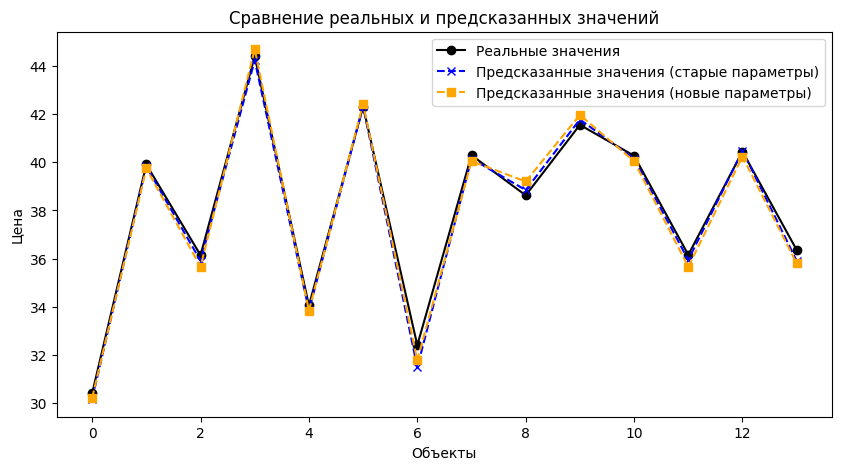

In [33]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Загрузка датасета
df = pd.read_csv("../../datasets/nuforc_reports.csv").head(100).dropna()

# Вывод первых строк для проверки структуры
print(df.head())

# Целевая переменная
target = df['city_latitude']

# Удаление целевой переменной из признаков
features = df.drop(columns=['summary', 'stats', 'report_link', 'posted', "duration"])

# Определение столбцов для обработки
num_columns = features.select_dtypes(include=['number']).columns
cat_columns = features.select_dtypes(include=['object']).columns

# Препроцессинг числовых столбцов
num_imputer = SimpleImputer(strategy="median")
num_scaler = StandardScaler()
preprocessing_num = Pipeline([
    ("imputer", num_imputer),
    ("scaler", num_scaler),
])

# Препроцессинг категориальных столбцов
cat_imputer = SimpleImputer(strategy="constant", fill_value="unknown")
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
preprocessing_cat = Pipeline([
    ("imputer", cat_imputer),
    ("encoder", cat_encoder),
])

# Объединение препроцессинга
features_preprocessing = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("preprocessing_num", preprocessing_num, num_columns),
        ("preprocessing_cat", preprocessing_cat, cat_columns),
    ],
    remainder="passthrough"
)

# Создание финального пайплайна
pipeline_end = Pipeline([
    ("features_preprocessing", features_preprocessing),
])

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Применение пайплайна к данным
X_train_processed = pipeline_end.fit_transform(X_train)
X_test_processed = pipeline_end.transform(X_test)

# 1. Настройка параметров для старых значений
old_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Подбор гиперпараметров с помощью Grid Search для старых параметров
old_grid_search = GridSearchCV(estimator=RandomForestRegressor(),
                               param_grid=old_param_grid,
                               scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=2)

# Обучение модели на тренировочных данных
old_grid_search.fit(X_train_processed, y_train)

# Результаты подбора для старых параметров
old_best_params = old_grid_search.best_params_
old_best_mse = -old_grid_search.best_score_

# 2. Настройка параметров для новых значений
new_param_grid = {
    'n_estimators': [200],
    'max_depth': [10],
    'min_samples_split': [10]
}

# Подбор гиперпараметров с помощью Grid Search для новых параметров
new_grid_search = GridSearchCV(estimator=RandomForestRegressor(),
                               param_grid=new_param_grid,
                               scoring='neg_mean_squared_error', cv=2)

# Обучение модели на тренировочных данных
new_grid_search.fit(X_train_processed, y_train)

# Результаты подбора для новых параметров
new_best_params = new_grid_search.best_params_
new_best_mse = -new_grid_search.best_score_

# 5. Обучение модели с лучшими параметрами для новых значений
model_best = RandomForestRegressor(**new_best_params)
model_best.fit(X_train_processed, y_train)

# Прогнозирование на тестовой выборке
y_pred = model_best.predict(X_test_processed)

# Оценка производительности модели
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Вывод результатов
print("Старые параметры:", old_best_params)
print("Лучший результат (MSE) на старых параметрах:", old_best_mse)
print("\nНовые параметры:", new_best_params)
print("Лучший результат (MSE) на новых параметрах:", new_best_mse)
print("Среднеквадратическая ошибка (MSE) на тестовых данных:", mse)
print("Корень среднеквадратичной ошибки (RMSE) на тестовых данных:", rmse)

# Обучение модели с лучшими параметрами для старых значений
model_old = RandomForestRegressor(**old_best_params)
model_old.fit(X_train_processed, y_train)

# Прогнозирование на тестовой выборке для старых параметров
y_pred_old = model_old.predict(X_test_processed)

# Визуализация ошибок
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Реальные значения', marker='o', linestyle='-', color='black')
plt.plot(y_pred_old, label='Предсказанные значения (старые параметры)', marker='x', linestyle='--', color='blue')
plt.plot(y_pred, label='Предсказанные значения (новые параметры)', marker='s', linestyle='--', color='orange')
plt.xlabel('Объекты')
plt.ylabel('Цена')
plt.title('Сравнение реальных и предсказанных значений')
plt.legend()
plt.show()
